In [1]:
import torch
import os
import numpy as np
from torch.utils.data import DataLoader
import matplotlib
import matplotlib.pyplot as plt
import import_ipynb
import importance_sampler_poise
import data_preprocessing
from torchvision.utils import save_image
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
import torchvision.transforms as transforms
from torch.nn import functional as F  #for the activation function
from torchviz import make_dot
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
import torchvision
import umap
import random
import shutil

importing Jupyter notebook from importance_sampler_poise.ipynb
importing Jupyter notebook from data_preprocessing.ipynb


In [2]:
# learning parameters
latent_dim1 = 32
latent_dim2 = 16
batch_size = 256
dim_MNIST   = 784
lr = 1e-4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tx = transforms.ToTensor()
MNIST_TRAINING_PATH = "/home/achint/Practice_code/VAE/MNIST/MNIST/processed/training.pt"
SVHN_TRAINING_PATH  = "/home/achint/Practice_code/VAE/SVHN/train_32x32.mat"
MNIST_TEST_PATH     = "/home/achint/Practice_code/VAE/MNIST/MNIST/processed/test.pt"
SVHN_TEST_PATH  = "/home/achint/Practice_code/VAE/SVHN/test_32x32.mat"
SUMMARY_WRITER_PATH = "/home/achint/Practice_code/logs"
RECONSTRUCTION_PATH = "/home/achint/Practice_code/1_a_new_start/MNIST_SVHN_alternate1/reconstructions/"
PATH = "/home/achint/Practice_code/1_a_new_start/MNIST_SVHN_alternate1/weights.txt"

In [3]:
# Remove the logs directory and the reconstruction directory 
if os.path.exists(RECONSTRUCTION_PATH):
    shutil.rmtree(RECONSTRUCTION_PATH)
    os.makedirs(RECONSTRUCTION_PATH)

if os.path.exists(SUMMARY_WRITER_PATH):
    shutil.rmtree(SUMMARY_WRITER_PATH)
    os.makedirs(SUMMARY_WRITER_PATH)

In [4]:
## Importing MNIST and SVHN datasets
joint_dataset_train=data_preprocessing.JointDataset(mnist_pt_path=MNIST_TRAINING_PATH,
                             svhn_mat_path=SVHN_TRAINING_PATH)
joint_dataset_test = data_preprocessing.JointDataset(mnist_pt_path=MNIST_TEST_PATH,
                             svhn_mat_path=SVHN_TEST_PATH)

joint_dataset_train_loader = DataLoader(
    joint_dataset_train,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True
)
joint_dataset_test_loader = DataLoader(
    joint_dataset_test,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True
)

In [9]:
class VAE(nn.Module):
    def __init__(self,latent_dim1, latent_dim2, batch_size,use_mse_loss=True):
        super(VAE,self).__init__()
        self.latent_dim1 = latent_dim1
        self.latent_dim2 = latent_dim2
        self.batch_size = batch_size
        self.use_mse_loss = use_mse_loss
        self.n_IW_samples = 10
        self.IS_sampler              = importance_sampler_poise.importance_sampler(self.latent_dim1, self.latent_dim2, self.batch_size)
        ## Encoder set1(MNIST)
        self.set1_enc1 = nn.Linear(in_features = dim_MNIST,out_features = 512)
        self.set1_enc2 = nn.Linear(in_features = 512,out_features = 128)
        self.set1_enc3 = nn.Linear(in_features = 128,out_features = 2*latent_dim1)
        
        ## Decoder set1(MNIST)
        self.set1_dec1 = nn.Linear(in_features = latent_dim1,out_features = 128)
        self.set1_dec2 = nn.Linear(in_features = 128,out_features = 512)
        self.set1_dec3 = nn.Linear(in_features = 512,out_features = dim_MNIST)
        
        ## Encoder set2(SVHN)
        # input size: 3 x 32 x 32
        self.set2_enc1 = nn.Conv2d(in_channels=3, out_channels=2*latent_dim2, kernel_size=4, stride=2, padding=1)
        # size: 32 x 16 x 16
        self.set2_enc2 = nn.Conv2d(in_channels=2*latent_dim2, out_channels=2*latent_dim2, kernel_size=4, stride=2, padding=1)
        # size: 32 x 8 x 8
        self.set2_enc3 = nn.Conv2d(in_channels=2*latent_dim2, out_channels=latent_dim2, kernel_size=4, stride=2, padding=1)
        # size: 16 x 4 x 4    

        ## Decoder set2(SVHN)
        # input size: 16x1x1
        self.set2_dec0 = nn.ConvTranspose2d(in_channels=latent_dim2,out_channels=latent_dim2, kernel_size=4, stride=1, padding=0)
        # input size: 16x4x4
        self.set2_dec1 = nn.ConvTranspose2d(in_channels=latent_dim2,out_channels=2*latent_dim2, kernel_size=3, stride=1, padding=1)
        # size: 32 x 4 x 4
        self.set2_dec2 = nn.ConvTranspose2d(in_channels=2*latent_dim2,out_channels=2*latent_dim2, kernel_size=5, stride=1, padding=0)
        # size: 32 x 8 x 8
        self.set2_dec3 = nn.ConvTranspose2d(in_channels=2*latent_dim2,out_channels=2*latent_dim2, kernel_size=4, stride=2, padding=1)
        # size: 32 x 16 x 16
        self.set2_dec4 = nn.ConvTranspose2d(in_channels=2*latent_dim2,out_channels=3, kernel_size=4, stride=2, padding=1)
        # size: 3 x 32 x 32
        
        self.SVHNc1 = nn.Conv2d(latent_dim2, latent_dim2, 4, 1, 0)
        # size: 16 x 1 x 1
        self.SVHNc2 = nn.Conv2d(latent_dim2, latent_dim2, 4, 1, 0)
        # size: 16 x 1 x 1
        self.register_parameter(name='g11', param = nn.Parameter(torch.randn(latent_dim1,latent_dim2)))
        self.register_parameter(name='g22', param = nn.Parameter(torch.randn(latent_dim1,latent_dim2)))
        self.g12= torch.zeros(latent_dim1,latent_dim2).to(device)
        
        ## Mean and variance(MNIST)
        self.set3_enc1 = nn.Linear(in_features = dim_MNIST,out_features = 512)
        self.set3_enc2 = nn.Linear(in_features = 512,out_features = 128)
        self.set3_enc3 = nn.Linear(in_features = 128,out_features = 2*latent_dim1)
        
        ## Mean and variance(SVHN)
        # input size: 3 x 32 x 32
        self.set4_enc1 = nn.Conv2d(in_channels=3, out_channels=2*latent_dim2, kernel_size=4, stride=2, padding=1)
        # size: 32 x 16 x 16
        self.set4_enc2 = nn.Conv2d(in_channels=2*latent_dim2, out_channels=2*latent_dim2, kernel_size=4, stride=2, padding=1)
        # size: 32 x 8 x 8
        self.set4_enc3 = nn.Conv2d(in_channels=2*latent_dim2, out_channels=latent_dim2, kernel_size=4, stride=2, padding=1)
        # size: 16 x 4 x 4   
        self.SVHN41 = nn.Conv2d(latent_dim2, latent_dim2, 4, 1, 0)
        # size: 16 x 1 x 1
        self.SVHN42 = nn.Conv2d(latent_dim2, latent_dim2, 4, 1, 0)
        
        
    def weighted_mse_loss(self,weights,reconstruction,data):
        loss = torch.sum(weights * ((data - reconstruction) ** 2).T)
        return loss
    def forward(self,x1,x2):
        data1    = x1 #MNIST
        data2    = x2 #SVHN
        # Modality 1 (MNIST)
        x1       = F.relu(self.set1_enc1(x1))
        x1       = F.relu(self.set1_enc2(x1))  
        x1       = self.set1_enc3(x1).view(-1,2,latent_dim1)  # ->[128,2,32]
        mu1      = x1[:,0,:] # ->[128,32]
        log_var1 = x1[:,1,:] # ->[128,32]
        var1     = -torch.exp(log_var1)           #lambdap_2<0
        # Modality 2 (SVHN)
        x2 = x2.view(-1,3, 32,32) 
        x2 = F.relu(self.set2_enc1(x2))
        x2 = F.relu(self.set2_enc2(x2))
        x2 = F.relu(self.set2_enc3(x2))
        # get 'mu' and 'log_var' for SVHN
        mu2      = (self.SVHNc1(x2).squeeze(3)).squeeze(2)
        log_var2 = (self.SVHNc2(x2).squeeze(3)).squeeze(2)
        var2     = -torch.exp(log_var2)       
        g22      = -torch.exp(self.g22)     
        G1       = torch.cat((self.g11,self.g12),0)
        G2       = torch.cat((self.g12,g22),0)
        G        = torch.cat((G1,G2),1)
        
        ## Mean and variance MNIST
        x3       = F.relu(self.set3_enc1(data1))
        x3       = F.relu(self.set3_enc2(x3))  
        x3       = self.set3_enc3(x3).view(-1,2,latent_dim1)  # ->[128,2,32]
        mu3      = torch.mean(x3[:,0,:],0) 
        log_var3 = x3[:,1,:] # ->[128,32]
        var3     = torch.mean(torch.exp(log_var3),0)          
        
        ## Mean and variance SVHN
        x4 = data2.view(-1,3, 32,32) 
        x4 = F.relu(self.set4_enc1(x4))
        x4 = F.relu(self.set4_enc2(x4))
        x4 = F.relu(self.set4_enc3(x4))
        mu4      = torch.mean( (self.SVHN41(x4).squeeze(3)).squeeze(2),0 )
        log_var4 = (self.SVHN42(x4).squeeze(3)).squeeze(2)
        var4     = torch.mean(torch.exp(log_var4),0 )      

        z1_prior,z2_prior,z1_posterior,z2_posterior,IS_weights_prior,IS_weights_post = self.IS_sampler.calc(G,mu1,var1,mu2,var2,self.n_IW_samples,mu3,var3,mu4,var4)
        
        total_reconstruction_loss = 0
        weighted_reconstruction1 = torch.zeros_like(data1)               #[batch_size,2]
        weighted_reconstruction2 = torch.zeros_like(data2)
        for i in range(self.n_IW_samples):
            self.z1_IS_prior     = z1_prior[i]
            self.z2_IS_prior     = z2_prior[i]
            self.z1_IS_posterior = z1_posterior[i]
            self.z2_IS_posterior = (z2_posterior[i].unsqueeze(2)).unsqueeze(3)
            # decoding for MNIST
            x1 = F.relu(self.set1_dec1(self.z1_IS_posterior))
            x1 = self.set1_dec2(x1)
            # decoding for SVHN
            x2 = F.relu(self.set2_dec0(self.z2_IS_posterior))
            x2 = F.relu(self.set2_dec1(x2))
            x2 = F.relu(self.set2_dec2(x2))
            x2 = F.relu(self.set2_dec3(x2))
            self.z2_IS_posterior = self.z2_IS_posterior.squeeze()
#             part_fun0,part_fun1,part_fun2 = self.kl_div.calc(G,self.z1_IS_posterior,self.z2_IS_posterior,self.z1_IS_prior,self.z2_IS_prior,mu1,var1,mu2,var2)
            if self.use_mse_loss:
                reconstruction1 = self.set1_dec3(x1)
                reconstruction2 = (self.set2_dec4(x2)).view(-1,3072)
                MSE1 = self.weighted_mse_loss(IS_weights_post[i,:],reconstruction1, data1)
                MSE2 = self.weighted_mse_loss(IS_weights_post[i,:],reconstruction2, data2)
#             else:
#                 reconstruction1 = torch.sigmoid(self.set1_dec3(x1))
#                 reconstruction2 = torch.sigmoid((self.set2_dec4(x2)).view(-1,3072))
#                 bce_loss = nn.BCELoss(reduction='sum')
#                 MSE1 = bce_loss(reconstruction1, data1)
#                 MSE2 = bce_loss(reconstruction2, data2)
            total_reconstruction_loss = total_reconstruction_loss+MSE1+MSE2
            KLD =torch.zeros_like(total_reconstruction_loss)
            weighted_reconstruction1 = weighted_reconstruction1 + (IS_weights_post[i,:]*reconstruction1.T).T
            weighted_reconstruction2 = weighted_reconstruction2 + (IS_weights_post[i,:]*reconstruction2.T).T
        return self.z1_IS_posterior,self.z2_IS_posterior,weighted_reconstruction1,weighted_reconstruction2,mu1,var1,mu2,var2,total_reconstruction_loss, MSE1, MSE2, KLD

In [10]:
# state = torch.load(PATH)
model = VAE(latent_dim1, latent_dim2, batch_size,use_mse_loss=True).to(device)
optimizer = optim.Adam(model.parameters(),lr=lr)
# model.load_state_dict(state['state_dict'])
# optimizer.load_state_dict(state['optimizer'])

# for name, para in model.named_parameters():
#     print(name)

In [11]:
def train(model,joint_dataloader,epoch):
    model.train()
    running_loss = 0.0
    running_mse1 = 0.0
    running_mse2 = 0.0
    running_kld  = 0.0
    running_loss = 0.0
    for i,joint_data in enumerate(joint_dataloader):
        data1    = joint_data[0]
        data1    = data1.float()
        data2    = joint_data[1]
        data2    = data2.float()
        data1    = data1.to(device)
        data2    = data2.to(device)
        data1    = data1.view(data1.size(0), -1)
        data2    = data2.view(data2.size(0), -1)
        optimizer.zero_grad()
        z1_posterior,z2_posterior,reconstruction1,reconstruction2,mu1,var1,mu2,var2,loss, MSE1, MSE2, KLD       = model(data1,data2) 
        running_mse1 += MSE1.item()
        running_mse2 += MSE2.item()
        running_kld  += KLD.item()
        running_loss += loss.item()          #.item converts tensor with one element to number
        loss.backward()                      #.backward
        optimizer.step()                     #.step one learning step
    train_loss = running_loss/(len(joint_dataloader.dataset))
    mse1_loss = running_mse1 / (len(joint_dataloader.dataset))
    mse2_loss = running_mse2 / (len(joint_dataloader.dataset))
    kld_loss = running_kld / (len(joint_dataloader.dataset))
#     for name, param in model.named_parameters():
#         writer.add_histogram(name, param.clone().cpu().data.numpy(), epoch)
    writer.add_scalar("training/loss", train_loss, epoch)
    writer.add_scalar("training/MSE1", mse1_loss, epoch)
    writer.add_scalar("training/MSE2", mse2_loss, epoch)
    writer.add_scalar("training/KLD", kld_loss, epoch)    
    return train_loss
    
def test(model,joint_dataloader,epoch):
    latent_repMNIST= []
    latent_repSVHN= []
    label_mnist= []
    label_svhn= []
    model.eval()
    running_loss = 0.0
    running_mse1 = 0.0
    running_mse2 = 0.0
    running_kld  = 0.0
    running_loss = 0.0
    with torch.no_grad():
        for i,joint_data in enumerate(joint_dataloader):
            data1   = joint_data[0]
            data1   = data1.float()

            data2  =joint_data[1]
            data2 = data2.float()

            label1  =joint_data[2]
            label2  =joint_data[3]
            
            data1 = data1.to(device)
            data2 = data2.to(device)
            data1 = data1.view(data1.size(0), -1)
            data2 = data2.view(data2.size(0), -1)
            
            z1_posterior,z2_posterior,reconstruction1,reconstruction2,mu1,var1,mu2,var2,loss, MSE1, MSE2, KLD = model(data1,data2)  
            running_loss += loss.item()
            running_mse1 += MSE1.item()
            running_mse2 += MSE2.item()
            running_kld  += KLD.item()    
            
            latent_repMNIST.append(z1_posterior)
            latent_repSVHN.append(z2_posterior)
            label_mnist.append(label1)
            label_svhn.append(label2)

            #save the last batch input and output of every epoch
            if i == int(len(joint_dataloader.dataset)/joint_dataloader.batch_size) - 1:
                num_rows = 8
                both = torch.cat((data1.view(batch_size, 1, 28, 28)[:8], 
                                  reconstruction1.view(batch_size, 1, 28, 28)[:8]))
                bothp = torch.cat((data2.view(batch_size, 3, 32, 32)[:8], 
                                  reconstruction2.view(batch_size, 3, 32, 32)[:8]))
                save_image(both.cpu(), os.path.join(RECONSTRUCTION_PATH, f"1_outputMNIST_{epoch}.png"), nrow=num_rows)
                save_image(bothp.cpu(), os.path.join(RECONSTRUCTION_PATH, f"1_outputSVHN_{epoch}.png"), nrow=num_rows)
    test_loss = running_loss/(len(joint_dataloader.dataset))
    mse1_loss = running_mse1 / (len(joint_dataloader.dataset))
    mse2_loss = running_mse2 / (len(joint_dataloader.dataset))
    kld_loss = running_kld / (len(joint_dataloader.dataset))
    writer.add_scalar("validation/loss", test_loss, epoch)
    writer.add_scalar("validation/MSE1", mse1_loss, epoch)
    writer.add_scalar("validation/MSE2", mse2_loss, epoch)
    writer.add_scalar("validation/KLD", kld_loss, epoch)
    latent_repMNIST = torch.vstack(latent_repMNIST).cpu().numpy()
    latent_repSVHN  = torch.vstack(latent_repSVHN).cpu().numpy()
    label_mnist     = torch.hstack(label_mnist).cpu().numpy()
    label_svhn      = torch.hstack(label_svhn).cpu().numpy()
    return test_loss,latent_repMNIST,latent_repSVHN,label_mnist,label_svhn


In [12]:
train_loss = []
test_loss = []
epochs = 50
writer=SummaryWriter(SUMMARY_WRITER_PATH)
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = train(model,joint_dataset_train_loader,epoch)
    test_epoch_loss,latent_repMNIST,latent_repSVHN,label_mnist,label_svhn = test(model,joint_dataset_test_loader,epoch)
    train_loss.append(train_epoch_loss)
    test_loss.append(test_epoch_loss)     
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Test Loss: {test_epoch_loss:.4f}")

Epoch 1 of 50
Train Loss: 374.6197
Test Loss: 255.8579
Epoch 2 of 50
Train Loss: 201.4709
Test Loss: 221.6346
Epoch 3 of 50
Train Loss: 183.0609
Test Loss: 211.9300
Epoch 4 of 50
Train Loss: 177.3424
Test Loss: 212.7623
Epoch 5 of 50
Train Loss: 175.5793
Test Loss: 210.8173
Epoch 6 of 50
Train Loss: 174.6799
Test Loss: 210.4817
Epoch 7 of 50
Train Loss: 173.9013
Test Loss: 211.1680
Epoch 8 of 50
Train Loss: 175.4169
Test Loss: 206.8578
Epoch 9 of 50
Train Loss: 174.7868
Test Loss: 208.4602
Epoch 10 of 50
Train Loss: 173.9041
Test Loss: 208.6984
Epoch 11 of 50
Train Loss: 174.0071
Test Loss: 207.5024
Epoch 12 of 50
Train Loss: 173.5986
Test Loss: 208.8172
Epoch 13 of 50
Train Loss: 174.1179
Test Loss: 210.3615
Epoch 14 of 50
Train Loss: 173.8109
Test Loss: 210.7253
Epoch 15 of 50
Train Loss: 173.7556
Test Loss: 208.4845
Epoch 16 of 50
Train Loss: 173.7379
Test Loss: 205.3037
Epoch 17 of 50
Train Loss: 173.3191
Test Loss: 207.3819
Epoch 18 of 50


KeyboardInterrupt: 

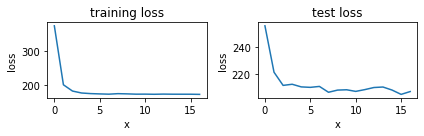

In [13]:
flg,(ax1,ax2)=plt.subplots(1,2,figsize=(6, 2))
ax1.plot(train_loss)
ax1.set(xlabel='x',ylabel='loss',title='training loss')
ax2.plot(test_loss)
ax2.set(xlabel='x',ylabel='loss',title='test loss')
flg.tight_layout()
plt.show()

In [14]:
# weights = torch.randn(64)
# data = torch.randn(64,784)
# reconstruction = data
# loss = torch.sum( weights*((data - reconstruction) ** 2).T)


In [15]:
state = {
    'epoch': epoch,
    'state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict()}
torch.save(state, PATH)